# 1. Preliminary: Preparations
In this section, we includes all of the preparation needed to run our experiments. This includes
1. A import of all of the utility libraries
2. A load of functions needed in our context
3. A load of hyperparameter needed

## 1.1 Import Utility Libraries

In [46]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import graphviz as gr
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm

# Makes sure the seed is different and random everytime we load the libraries
random.seed(np.random.randint(0,100))

## 1.2. Load Context Libries
- In the following block, we will load all of the necessary library functions specific to our task.

In [47]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
# Note this is equivalent to np.var(Yt,ddof)

def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
# Note this is equivalent to np.var(Yt,ddof)

def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
    
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    n_values = []
    tauhats = []
    sehats = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]   
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        
    return (n_values,tauhats,sehats,lb,ub)


## 1.3: Experiment Class Definition

In [48]:
tau = 2
corr = .5
conf=False
p = 100
p0 = 50
flagX = 1
N = 1000

class Experiment:

  def __init__(self):
    pass
  
  def __str__(self):
    return f"Context : tau = {self.tau}, corr = {self.corr}, conf = {self.conf}, p = {self.p}, p0 = {self.p0}, flagX = {flagX}, N = {N}"

  def context_load(self,tau,corr,conf,p,p0,flagX,N):
    self.tau = tau
    self.corr = corr
    self.conf = conf
    self.p = p
    self.p0 = p0
    self.flagX = flagX
    self.N = N
  
  def DGP_experiment1(self,save_csv='None'):
    """ Simulates a DGP with the hyperparameters given 
    Args: 
      save_csv (str): saves csv with the file name given 

    Returns:
      A dataframe of the generated data

    """
    Y,T,X = fn_generate_data(self.tau,self.N,self.p,self.p0,self.corr,self.conf,self.flagX)
    data = pd.DataFrame(np.concatenate([Y,T,X], axis=1))
    print("Data generated with " + self.__str__())
    display(data)
    
    
    if save_csv != 'None':
      data.to_csv(save_csv)
    
  def monte_carlo(self,N_list,R):
    """ Simulates a Monte_Carlo with the hyperparameters given
    Args: 
      N_list (list-like): The number of simulations to run 

    Returns:
      A analysis on the estimated tau

    """


# 2. Environment 1: DGP with covariates:
Here, we will work with the following environment:$$Y = \tau*T+\beta'*X+e$$

We attempt to analyze this environment with four approaches:
1. Simulate a DGP
2. Illustrate DGP with DAG
3. Monte Carlo Experiment
4. Provide a real-life example where this environment might have take place

In [50]:
experiment1 = Experiment()

## 2.1.Simulate a DGP

In [52]:
experiment1.context_load(tau = 5,corr = .5,conf=False,p = 10,p0 = 10,flagX = 1,N = 1000)

experiment1.DGP_experiment1(save_csv = "experiment1_data.csv")

Data generated with Context : tau = 5, corr = 0.5, conf = False, p = 10, p0 = 10, flagX = 1, N = 1000


,0,1,2,3,4,5,6,7,8,9,10,11
0,-23.066153,1.0,-0.619715,-0.409595,0.051123,-0.653007,-2.266061,-0.842047,-0.543099,-1.323340,0.320817,-0.013815
1,-32.167956,0.0,-2.036759,0.315053,-0.076482,0.326428,0.583478,-0.863824,-0.532494,-0.736548,-0.885278,-0.536550
2,-19.897460,0.0,-0.552580,-1.193672,-0.448974,0.009901,1.163386,-0.634438,-0.048449,-0.722991,0.062281,-1.238948
3,56.164266,1.0,1.050837,0.747434,1.359202,0.732005,1.128864,0.237570,0.983800,0.258204,1.558166,-0.066812
4,4.888887,1.0,-0.923931,-0.014647,-1.187197,0.200355,0.869809,1.281146,-0.404164,-0.011662,1.065090,-0.223672
...,...,...,...,...,...,...,...,...,...,...,...,...
995,48.463334,1.0,0.428039,0.980896,0.740759,1.198462,0.720961,0.905853,0.977105,1.891551,0.830443,0.626460
996,-4.459582,1.0,-0.084850,-1.411363,-1.006342,-0.346813,-0.431944,0.130147,-0.424787,-0.241145,1.176952,0.080206
997,56.255447,1.0,1.688552,-0.459032,1.565500,1.174936,1.529734,0.496188,0.571821,1.063741,-0.000280,0.673729
998,43.523842,0.0,0.831329,0.268950,0.099929,0.040925,2.373481,1.255437,0.564513,0.202533,1.114641,1.327787


## 2.2 Illustrate DGP with a DAG

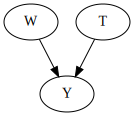

In [53]:
g = gr.Digraph()
g.edge("W", "Y")
g.edge("T", "Y")
g

## 2.3. Monte Carlo experiment


###  2.3 a.) Do not control for any covariates
Since we are not controlling the covariates, the observed RMSE is high

In [55]:
def monte_carlo_experiment1_a():
  p = 10
  p0 = 10
  estDict = {}
  R = 500
  for N in [100,1000]:
      tauhats = []
      sehats = []
      for r in tqdm(range(R)):
          Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
          Yt = Yexp[np.where(T==1)[0],:]
          Yc = Yexp[np.where(T==0)[0],:]

          # Since we do not control any covaraites, we only perform regression on T
          mod = sm.OLS(Yexp,T)
          res = mod.fit()
          tauhat = res.params[0]
          se_tauhat = res.HC1_se[0]    
          tauhats = tauhats + [tauhat]
          sehats = sehats + [se_tauhat]
      estDict[N] = {
          'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
          'sehat':np.array(sehats).reshape([len(sehats),1])
      }
      tau0 = tau*np.ones([R,1])
  # Prints empty line to format with tqdm
  print()
  for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                          results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

monte_carlo_experiment1_a()

100%|█████████████████████████████████████████| 500/500 [00:05<00:00, 87.79it/s]


N=100: bias=0.4216873456396987, RMSE=5.445688428841808, size=0.048
N=1000: bias=0.03670899940555099, RMSE=1.7645049995991302, size=0.052


### 2.3 b.) Control for all the covariates that affect the outcome
Here, since we are controlling the covariates, the observed RMSE is significantly smaller

In [36]:
def monte_carlo_experiment1_b():
  estDict = {}
  R = 500
  for N in [100,1000]:
      tauhats = []
      sehats = []
      for r in tqdm(range(R)):
          Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
          Xobs = X[:,:p0]
          covars = np.concatenate([T,Xobs],axis = 1)
          mod = sm.OLS(Yexp,covars)
          res = mod.fit()
          tauhat = res.params[0]
          se_tauhat = res.HC1_se[0]    
          tauhats = tauhats + [tauhat]
          sehats = sehats + [se_tauhat]
      estDict[N] = {
          'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
          'sehat':np.array(sehats).reshape([len(sehats),1])
      }
  tau0 = tau*np.ones([R,1])
  # Prints empty line to format with tqdm
  print()
  for N, results in estDict.items():
      (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                          results['sehat'])
      print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
monte_carlo_experiment1_b()

100%|█████████████████████████████████████████| 500/500 [00:11<00:00, 45.08it/s]


N=100: bias=0.008064652747538596, RMSE=0.18605683271546575, size=0.04
N=1000: bias=0.0009147741817410288, RMSE=0.04360676340089051, size=0.048


## 2.4. Example of a real-life

Y = Test Score

T = Studying Technique

W = Time Spending on Study

# 3. Environment 2: DGP with a confounder:
Here, we will work with the following environment:$$T = a*C+u$$

We attempt to analyze this environment with four approaches:
1. Simulate a DGP
2. Illustrate DGP with DAG
3. Monte Carlo Experiment
4. Provide a real-life example where this environment might have take place

## 3.1.Simulate a DGP

In [37]:
def fn_generate_data2(tau,N,p,corr):
    
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal
    allX = fn_generate_multnorm(N,corr,nvar)
    
    C = allX[:,1].reshape([N,1]) # confounder
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    
    Tab = T+0.5*C
    Yab = tau*Tab+0.6*C+err
    return (Yab,Tab,C)

In [38]:
tau = 2
p = 100
corr = .5
N = 1000
Y,T,C = fn_generate_data2(tau,N,p,corr)
data2 = pd.DataFrame(np.concatenate([Y,T,C], axis=1))
display(data2)
data2.to_csv('experiment2_data.csv')

,0,1,2
0,-0.085337,0.323906,0.647813
1,2.165347,0.497494,0.994989
2,0.881637,0.654416,-0.691168
3,-1.747511,-0.519842,-1.039684
4,3.804141,0.679794,1.359588
...,...,...,...
995,-2.210302,-0.794180,-1.588360
996,5.211269,2.155716,2.311432
997,1.828931,0.864157,-0.271686
998,-0.408871,0.355175,-1.289650


## 3.2.Illustrate DGP with a DAG

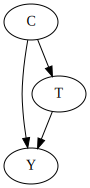

In [39]:
g = gr.Digraph()
g.edge("C", "Y")
g.edge("T", "Y")
g.edge("C", "T")
g

## 3.3 Monte Carlo experiment


###  3.3 a.) Fail to control for the confounder

In [40]:
def monte_carlo_experiment2_a():
  estDict = {}
  R = 500
  for N in [100,1000]:
      tauhats = []
      sehats = []
      for r in tqdm(range(R)):
          Yexp,T,C = fn_generate_data2(tau,N,p,corr)
          mod = sm.OLS(Yexp,T)
          res = mod.fit()
          tauhat = res.params[0]
          se_tauhat = res.HC1_se[0]
          tauhats = tauhats + [tauhat]
          sehats = sehats + [se_tauhat]
      estDict[N] = {
          'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
          'sehat':np.array(sehats).reshape([len(sehats),1])
      }
  # Prints empty line to format with tqdm
  print()
  tau0 = tau*np.ones([R,1])
  for N, results in estDict.items():
      (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                          results['sehat'])
      print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

monte_carlo_experiment2_a()

100%|█████████████████████████████████████████| 500/500 [00:08<00:00, 59.57it/s]


N=100: bias=0.3789509301283086, RMSE=0.4158223605492153, size=0.758
N=1000: bias=0.38659006552883324, RMSE=0.40245529811242253, size=0.992


###  3.3 b.) Control for the confounder

In [41]:
def monte_carlo_experiment2_b():
  estDict = {}
  R = 500
  for N in [100,1000]:
      tauhats = []
      sehats = []
      for r in tqdm(range(R)):
          Yexp,T,C = fn_generate_data2(tau,N,p,corr)
          covars = np.concatenate([T,C],axis = 1)
          mod = sm.OLS(Yexp,covars)
          res = mod.fit()
          tauhat = res.params[0]
          se_tauhat = res.HC1_se[0]
          tauhats = tauhats + [tauhat]
          sehats = sehats + [se_tauhat]
      estDict[N] = {
          'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
          'sehat':np.array(sehats).reshape([len(sehats),1])
      }
  # Prints empty line to format with tqdm
  print()
  tau0 = tau*np.ones([R,1])
  for N, results in estDict.items():
      (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                          results['sehat'])
      print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
monte_carlo_experiment2_b()

100%|█████████████████████████████████████████| 500/500 [00:08<00:00, 57.66it/s]


N=100: bias=-0.0008792699046429627, RMSE=0.1407389620157788, size=0.06
N=1000: bias=0.0008133885386832782, RMSE=0.04921348716171876, size=0.08


## 4.Example of a real-life

Y = Death

T = Diabetes

C = High Blood Pressure

# 4. Environment 3: DGP with selection bias:
Here, we will work with the following environment:
$$Y = \tau*T+e$$
and
$$S = a*T+b*Y+u$$

We attempt to analyze this environment with four approaches:
1. Simulate a DGP
2. Illustrate DGP with DAG
3. Monte Carlo Experiment
4. Provide a real-life example where this environment might have take place

## 4.1. Simulate a DGP

In [42]:
def fn_generate_data3(tau,N,p,corr):
    
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal
    allX = fn_generate_multnorm(N,corr,nvar)
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    u = np.random.normal(0,1,[N,1])
    
    Yab = tau*T+err
    S = 0.5*T+0.6*Yab+u
    return (Yab,T,S)

tau = 2
p = 50
corr = .5
N = 1000

Y,T,S = fn_generate_data3(tau,N,p,corr)
data3 = pd.DataFrame(np.concatenate([Y,T,S], axis=1))
display(data3)

,0,1,2
0,1.775708,1.0,2.661989
1,0.103785,0.0,0.244242
2,0.015526,0.0,-0.197796
3,1.517601,1.0,1.173982
4,-0.841222,0.0,-2.044158
...,...,...,...
995,-0.247455,0.0,-1.621714
996,-1.642517,0.0,-2.299402
997,1.777668,1.0,1.778914
998,0.447615,0.0,-0.255731


## 4.2.Illustrate DGP with a DAG

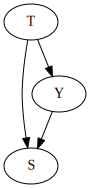

In [43]:
g = gr.Digraph()
g.edge("T", "S")
g.edge("T", "Y")
g.edge("Y", "S")
g

## 4.3.Monte Carlo experiment


###  4.3 a.)control for the variable in between the path from cause to effect

In [44]:
def monte_carlo_experiment3_a():
  estDict = {}
  R = 500
  for N in [100,1000]:
      tauhats = []
      sehats = []
      for r in tqdm(range(R)):
          Yexp,T,S = fn_generate_data3(tau,N,p,corr)
          covars = np.concatenate([T,S],axis = 1)
          mod = sm.OLS(Yexp,covars)
          res = mod.fit()
          tauhat = res.params[0]
          se_tauhat = res.HC1_se[0]
          tauhats = tauhats + [tauhat]
          sehats = sehats + [se_tauhat]
      estDict[N] = {
          'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
          'sehat':np.array(sehats).reshape([len(sehats),1])
      }
  print()
  tau0 = tau*np.ones([R,1])
  for N, results in estDict.items():
      (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                          results['sehat'])
      print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
monte_carlo_experiment3_a()

100%|█████████████████████████████████████████| 500/500 [00:06<00:00, 82.63it/s]


N=100: bias=-0.7551591082908319, RMSE=0.7753612240145913, size=0.98
N=1000: bias=-0.7510518080541199, RMSE=0.7531825367708121, size=1.0


###  4.3 b.)control for the variable in between the path from cause to effect

In [45]:
def monte_carlo_experiment3_b():
  estDict = {}
  R = 500
  for N in [100,1000]:
      tauhats = []
      sehats = []
      for r in tqdm(range(R)):
          Yexp,T,S = fn_generate_data3(tau,N,p,corr)
          Yt = Yexp[np.where(T==1)[0],:]
          Yc = Yexp[np.where(T==0)[0],:]
          mod = sm.OLS(Yexp,T)
          res = mod.fit()
          tauhat = res.params[0]
          se_tauhat = res.HC1_se[0]
          tauhats = tauhats + [tauhat]
          sehats = sehats + [se_tauhat]
      estDict[N] = {
          'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
          'sehat':np.array(sehats).reshape([len(sehats),1])
      }
  print()
  tau0 = tau*np.ones([R,1])
  for N, results in estDict.items():
      (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                          results['sehat'])
      print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
monte_carlo_experiment3_b()

100%|█████████████████████████████████████████| 500/500 [00:06<00:00, 72.33it/s]


N=100: bias=0.009052256494285836, RMSE=0.145911677665711, size=0.058
N=1000: bias=0.0028734400057015305, RMSE=0.04369651079190964, size=0.048


## 4.4 Example of a real-life
Suppose a man wanted to figure out the average salary of a bank employee. He took a list of individual income tax payers and started investigating. All of them made more than $2,500. There is selection bias in this result because the tax threshold is ignored, and only those earning more than the threshold will appear on the list. The sample in the study has selection bias.